In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import deepchem as dc
from deepchem.molnet import load_qm7, load_qm7_from_mat
from sklearn.kernel_ridge import KernelRidge
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole, rdMolDraw2D
from rdkit.Chem import Draw, rdDepictor
from IPython.display import SVG

from __future__ import print_function
from __future__ import division
from __future__ import unicode_literals

%matplotlib inline

In [2]:
tasks, datasets, transformers = load_qm7_from_mat(featurizer='CoulombMatrix', split='stratified', 
                                                      move_mean=True, reload=False)

train_dataset, valid_dataset, test_dataset = datasets



TIMING: dataset construction took 0.338 s
Loading dataset from disk.
TIMING: dataset construction took 0.288 s
Loading dataset from disk.
TIMING: dataset construction took 0.117 s
Loading dataset from disk.
TIMING: dataset construction took 0.116 s
Loading dataset from disk.
TIMING: dataset construction took 0.266 s
Loading dataset from disk.
TIMING: dataset construction took 0.034 s
Loading dataset from disk.
TIMING: dataset construction took 0.031 s
Loading dataset from disk.


In [3]:
train_dataset.X.shape

(5728, 23, 23)

In [5]:
# Fit models

# Batch size of models
batch_size = 50
n_embedding = 30
n_distance = 51
distance_min = -1.
distance_max = 9.2
n_hidden = 15
rate = 0.001

model = dc.models.DTNNModel(
    len(tasks),
    n_embedding=n_embedding,
    n_hidden=n_hidden,
    n_distance=n_distance,
    distance_min=distance_min,
    distance_max=distance_max,
    output_activation=False,
    batch_size=batch_size,
    learning_rate=rate,
    use_queue=False,
    tensorboard=True,
    model_dir='dtnn_models/',
    mode="regression")

# Fit trained model
model.fit(train_dataset, nb_epoch=50)


/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Users/nathalie.willems/anaconda3/envs/deepche

Ending global_step 999: Average loss 0.236288
Ending global_step 1999: Average loss 0.0225569
Ending global_step 2999: Average loss 0.0124712
Ending global_step 3999: Average loss 0.00734025
Ending global_step 4999: Average loss 0.0053977
Ending global_step 5750: Average loss 0.00432812
TIMING: model fitting took 229.261 s


0.004328123228943792

In [8]:
model.save()

NotImplementedError: 

In [7]:
## Predictions

predictions = model.predict(test_dataset)
valid = model.predict(valid_dataset)
results = pd.DataFrame(predictions, columns=['test_pred'])
results['valid_pred'] = valid
results['y_test'] = test_dataset.y
results['y_valid'] = valid_dataset.y

results.head(4)

,test_pred,valid_pred,y_test,y_valid
0,3.282637,3.068421,3.280482,3.049192
1,1.756954,1.774313,1.704961,1.688196
2,2.653056,1.985612,2.634614,1.951443
3,2.041220,2.579980,1.936835,2.616906


In [10]:
## Evaluation metrics

metric = [
    dc.metrics.Metric(dc.metrics.mean_absolute_error, mode="regression"),
    dc.metrics.Metric(dc.metrics.pearson_r2_score, mode="regression"),
    dc.metrics.Metric(dc.metrics.mean_squared_error, mode="regression")
]

train_scores = model.evaluate(train_dataset, metric, transformers)
valid_scores = model.evaluate(valid_dataset, metric, transformers)

computed_metrics: [9.128455]
computed_metrics: [0.9977441649465533]
computed_metrics: [148.19612]
computed_metrics: [9.692232]
computed_metrics: [0.9966452886111234]
computed_metrics: [198.0144]


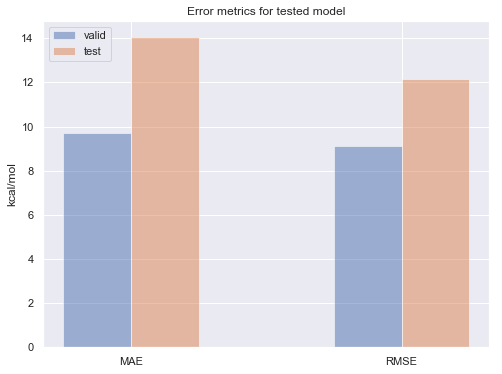

/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


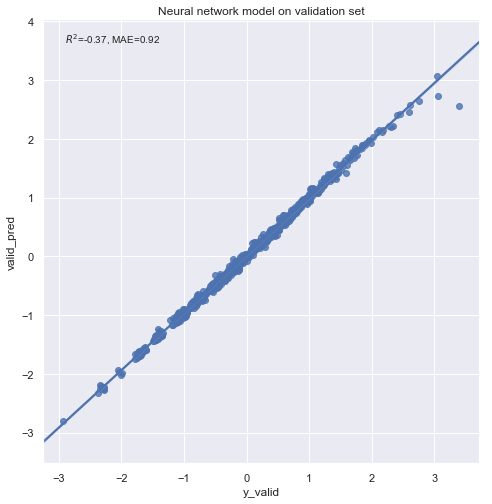

/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


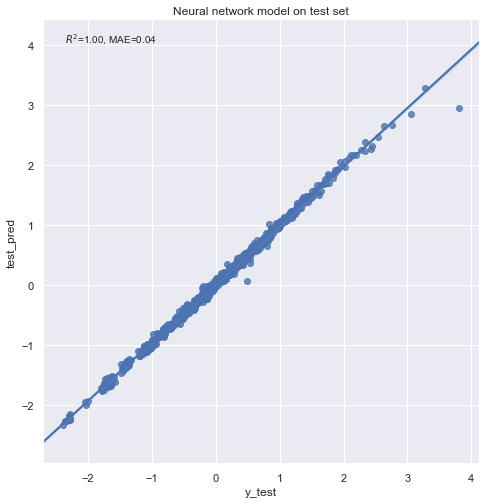

In [11]:
## Plot results
from sklearn import metrics 

pos = list(range(2))
width = 0.25

fig, ax = plt.subplots(figsize=(8,6))
plt.bar(pos,[valid_scores['mean_absolute_error'], train_scores['mean_absolute_error']],width,alpha=0.5, label='mae')
plt.bar([p + 1*width for p in pos], [np.sqrt(valid_scores['mean_squared_error']), np.sqrt(train_scores['mean_squared_error'])], width, 
        alpha=0.5, label='mse')

ax.set_title('Error metrics for tested model')
ax.set_xticks([p + 0.5 * width for p in pos])
ax.set_xticklabels(['MAE', 'RMSE'])
ax.set_ylabel('kcal/mol')

plt.legend(['valid', 'test'], loc='upper left')
plt.show()

sns.pairplot(results, x_vars='y_valid', y_vars='valid_pred', height=7, aspect=1, kind='reg')
plt.title("Neural network model on validation set")
plt.annotate('$R^2$=%.2f, MAE=%.2f' % (metrics.r2_score(valid_dataset.y, predictions), 
                                       metrics.mean_absolute_error(valid_dataset.y, predictions)), 
                                    xy=(0.05, 0.95), xycoords='axes fraction')
plt.show()

sns.pairplot(results, x_vars='y_test', y_vars='test_pred', height=7, aspect=1, kind='reg')
plt.title("Neural network model on test set")
plt.annotate('$R^2$=%.2f, MAE=%.2f' % (metrics.r2_score(test_dataset.y, predictions), 
                                       metrics.mean_absolute_error(test_dataset.y, predictions)), 
                                    xy=(0.05, 0.95), xycoords='axes fraction')
plt.show()

# fig, ax = plt.subplots(1, 1, figsize=(8,6))
# ax.bar(['train', 'test'], [train_scores['mean_absolute_error'], valid_scores['mean_absolute_error']])
# #ax[1].bar(['mae', 'pearsons_r2'], test_scores)
# plt.title("Deep tensor neural network")
# plt.ylabel("mean absolute error")
# plt.show()

In [ ]:
## Save model 
from sklearn.externals import joblib

# save the model to disk
# filename = 'dtnn_from_mat_22072019.sav'
# joblib.dump(model, filename)
model.get_params_filename("./")

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("dtnn_from_mat_22072019.json", "w") as json_file:
    json_file.write(model_json)